In [1]:
import os

# pandas and numpy for data manipulation
import numpy as np
import math

#scipy for algorithms
import scipy
from scipy import stats

import matplotlib.pyplot as plt

1D Gaussion Likelihood

In [2]:
#Form a population of 30000 individual
model = lambda t:np.random.normal(5, 6, t)
population = model(30000)
observation = population[np.random.randint(0, 30000, 1000)]

In [3]:
class GLikelihood:
    """
    General class for Gaussian likelihoods
    """
    
    # Initialize attributes Dim and Dataset
    def __init__(self, Dim, Dataset):
        # Dim[int]
        # Dataset[List[List[float]]]
        self.Dim = Dim
        self.Dataset = observation
        
    # Define prior
    def prior(self, x):
        # x[0] = mu, x[1] = sigma (new or current)
        # returns 1 for all valid values of sigma. Since Log(1) = 0, it doesn't affect anything.
        # returns 0 for all invalid values of sigma (<= 0). Since Log(0) = -infinity and Log(negative number) is undefined.
        if(x[1] <= 0):
            return 0
        return 1

    # Return likelihood of the data given a sigma (new or current) manually
    def likelihood_manual(self, x, data):
        # x[0] = mu, x[1] = sigma (new or current)
        # data = observation
        return np.sum(-np.log(x[1] * np.sqrt(2 * np.pi) ) - ((data - x[0]) ** 2) / (2 * x[1] ** 2))

    # Return likelihood of the data given a sigma (new or current) with scipy
    def likelihood(self, x, data):
        # x[0] = mu, x[1] = sigma (new or current)
        # data = observation
        return np.sum(np.log(scipy.stats.norm(x[0],x[1]).pdf(data)))


    # Decide whether accept or reject the new sample
    def acceptance(self, x, x_new):
        if x_new > x:
            return True
        else:
            accept = np.random.uniform(0, 1)
            return (accept < (np.exp(x_new-x)))

    # Define Metropolis Hastings
    def metropolis_hastings(self, likelihood_computer, 
                            prior, 
                            transition_model, 
                            param_init, 
                            iterations, 
                            data, 
                            acceptance_rule):
        # likelihood_computer(x, data): returns the likelihood that the parameters generated the data
        # transition_model(x): proposal distribution
        # param_init: the initial parameter
        # iterations: number of interations
        # data: the observational data we want to model
        # acceptance_rule(x, x_new): decides whether to accept or reject the new sample
        x = param_init
        accepted = []
        rejected = []   
        scores = []
        for i in range(iterations):
            x_new =  transition_model(x) 
            x_lik = likelihood_computer(x, data)
            x_new_lik = likelihood_computer(x_new, data) 
            if (acceptance_rule(x_lik + np.log(prior(x)), x_new_lik + np.log(prior(x_new)))):            
                x = x_new
                accepted.append(x_new)
                scores.append(x_new_lik)
            else:
                rejected.append(x_new)   
            if i % 1000 == 0:
                print('finished:{:.2f}%'.format((i / iterations) * 100))

        return np.array(accepted), np.array(rejected), np.array(scores)

In [4]:
# Tranistion model defines how to move from sigma_current to sigma_new
transition_model = lambda x: [x[0], np.random.normal(x[1], 0.5, (1,))]

In [5]:
g = GLikelihood(Dim = 2, Dataset = observation)

Run with initial parameters and collect accepted and rejected samples

In [6]:
accepted, rejected, scores = g.metropolis_hastings(g.likelihood, 
                                         g.prior, 
                                         transition_model, 
                                         [5, 5], 
                                         10000, 
                                         observation,
                                         g.acceptance)

finished:0.00%
finished:10.00%
finished:20.00%
finished:30.00%
finished:40.00%
finished:50.00%
finished:60.00%
finished:70.00%
finished:80.00%
finished:90.00%


/tmp/ipykernel_102844/2812743845.py:74: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(accepted), np.array(rejected), np.array(scores)


In [7]:
accepted[-10:,1]

array([array([6.3027352]), array([5.95469473]), array([5.9446901]),
       array([6.31485744]), array([6.27049165]), array([6.23855342]),
       array([6.26626426]), array([6.31977273]), array([6.31487979]),
       array([6.20268407])], dtype=object)

In [8]:
print(accepted.shape)
print(rejected.shape)

(3198, 2)
(6802, 2)


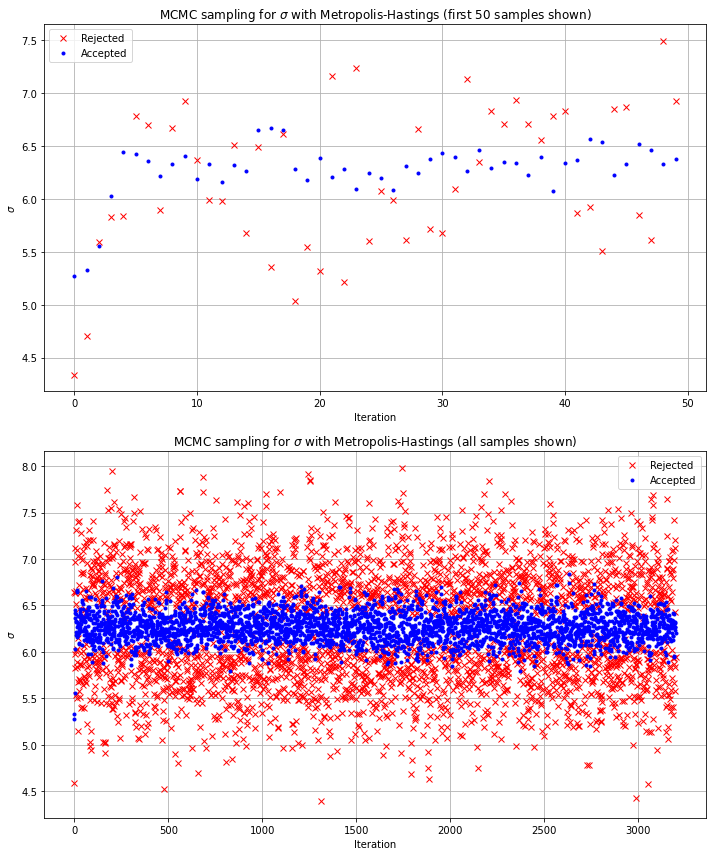

In [9]:
fig = plt.figure(figsize = (10, 12))

ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(rejected[0:50, 1], 'rx', label = 'Rejected')
ax1.plot(accepted[0:50, 1], 'b.', label = 'Accepted')
ax1.set_xlabel("Iteration")
ax1.set_ylabel("$\sigma$")
ax1.set_title("MCMC sampling for $\sigma$ with Metropolis-Hastings (first 50 samples shown)")
ax1.grid()
ax1.legend()

ax2 = fig.add_subplot(2, 1, 2)
to_show = -accepted.shape[0]
ax2.plot(rejected[to_show:, 1], 'rx', label = 'Rejected')
ax2.plot(accepted[to_show:, 1], 'b.', label = 'Accepted')
ax2.set_xlabel("Iteration")
ax2.set_ylabel("$\sigma$")
ax2.set_title("MCMC sampling for $\sigma$ with Metropolis-Hastings (all samples shown)")
ax2.grid()
ax2.legend()



fig.tight_layout()


We consider the initial 25% values as "burn-in"s and we drop them.
Then we visualize the trace of and the histogram of the trace.

In [10]:
# Drop the initial 25% of the values of sigma to be "burn-in"
show = int(-0.75 * accepted.shape[0])

accp = accepted[show:,1]

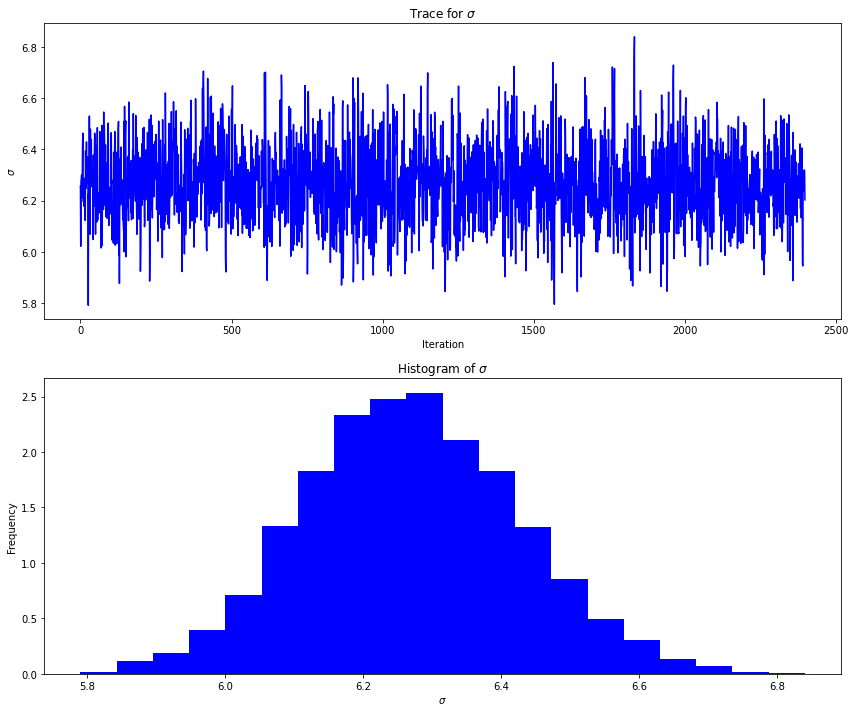

In [11]:
# visualize the trace of sigma and the histogram of the trace
fig = plt.figure(figsize = (12, 10))


ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(accp, color = 'b')
ax1.set_ylabel("$\sigma$")
ax1.set_xlabel("Iteration")
ax1.set_title("Trace for $\sigma$", fontsize = 12)

ax2 = fig.add_subplot(2, 1, 2)
ax2.hist(accp, bins = 20, density = True, stacked = True, color = ['b']*accp.size)
ax2.set_ylabel("Frequency")
ax2.set_xlabel("$\sigma$")
ax2.set_title("Histogram of $\sigma$", fontsize = 12)


fig.tight_layout()

Predictions

In [12]:
mu = accepted[show:,0].mean()
sigma = accepted[show:,1].mean()

print(mu, sigma)


5.0 [6.26878387]


In [13]:
model = lambda t, mu, sigma:np.random.normal(mu, sigma, t)
obs_gen = model(population.shape[0], mu, sigma)


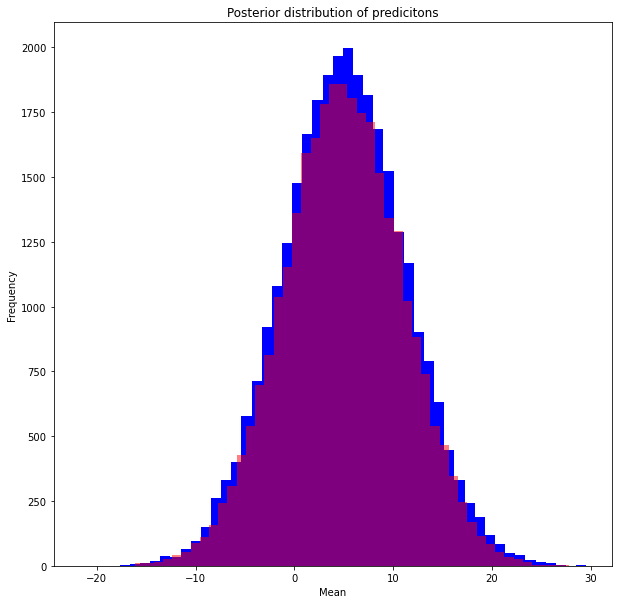

In [15]:
fig = plt.figure(figsize = (10, 10))

plt.hist(obs_gen, bins = 50, color = 'b', label = "Predicted distribution")
plt.hist(population, bins = 50, color = 'r', alpha = 0.5, label = "Original values")
plt.xlabel("Mean")
plt.ylabel("Frequency")
plt.title("Posterior distribution of predicitons")

plt.show()